# Class 3: Preprocessing
The steps in EEG preprocessing:

* Highpass filter
* Lowpass filter
* Artefact rejection
    * Ocular artifacts (EOG)
    * Heartbeat artifacts (ECG)
    * Power line noise
    * Methods:
        * Thresholding
        * ICA
* (Rereference)
* Epoching
* Evokeds (i.e. averaging)


__Libraries__

In [1]:
%matplotlib inline

In [2]:
import os
import mne
import numpy as np

__Download data__

In [3]:
# Downloading data
sample_data_folder = mne.datasets.sample.data_path()

# Data path
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_filt-0-40_raw.fif')

In [4]:
# Loading the data from the fif-file
raw = mne.io.read_raw_fif(sample_data_raw_file, preload=True)

Opening raw data file /home/ucloud/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...


In [5]:
# Picking only the EEG data (not MEG) + the stimulus onset times
raw.pick_types(meg=False, eeg=True, stim=True)

Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>


<Raw | sample_audvis_filt-0-40_raw.fif, 68 x 41700 (277.7 s), ~24.6 MB, data loaded>

__Filtering the data__

Default filtering for the sample data is:
* highpass: 0.1 Hz
* lowpass: 40 Hz

You can see this by:
print(raw.info)

In [ ]:
# Inspecting the raw data
print(raw.info)
# We can see that the data has already been filtered

__Manual filtering__

NB! Always apply the lowpass filter before the highpass filter, because this produces fewer artefacts (Mads was not quite sure about the order - check this)

NB! We do not need to filter twice, because this will change the data.

__Lowpass filter__

In [ ]:
# For filtering we can use the following function:
# First argument: high-pass
# Second argument: low-pass
# fir_design: "firwin" 
raw.filter(None, 40., fir_design='firwin')

__Highpass filtering__

In [ ]:
raw.filter(0.1, None, fir_design='firwin')

Sampling frequency: the number of samples per second.

__Removing eye blinks with ICA__

We use ICA (independent component analysis) to remove eye blink artifacts. ICA is a way of identifying different components that the data is made up of. EEG data is a linear combination of components. When we identify the components, we can remove the components with artifacts. 

*What is an EEG component?* <br>
Components in EEG and ICA mean different things. Components in EEG are the sub-parts of the evoked signals (e.g. P300 and N400). Hence, the EEG components are particular, systematic fluctuations happening at particular time points in the evoked signals, i.e. distinct patterns in the signal. <br>
In ICA a "component" is a mathematical construct. ICA is a way of breaking the signal into a number of components specified by us. When we set the number of components to 20, it means that the signal is broken into 20 components. When we add the componetns together we get the original signal. <br> 

Epochs = trials <br>
Evoked = average epochs

Fitting ICA to data using 59 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 14.5s.


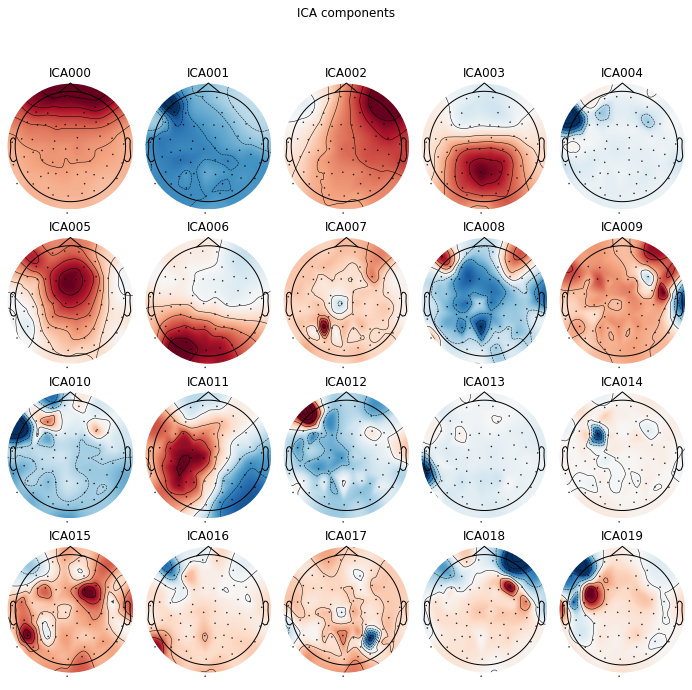

Creating RawArray with float64 data, n_channels=20, n_times=41700
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


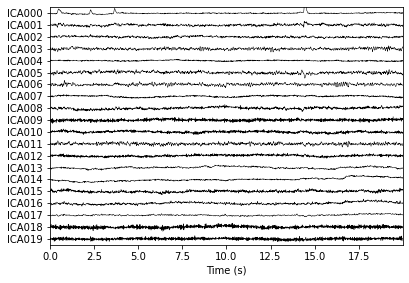

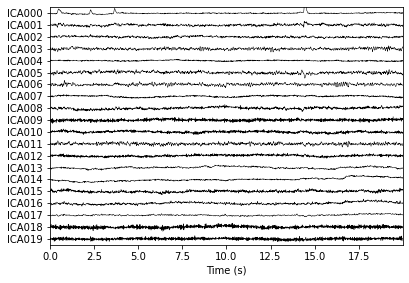

In [12]:
# Initialize ICA component
# We choose to split the signal into 20 components - instead, we could also have defined how much variance we wanted to explain (e.g. 95%)
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)

# Fit ICA to the raw data
ica.fit(raw)

# Plot components
ica.plot_components()
# The components are sorted based on how much variance they explain. 
# Typically, the eye blinks are at the top of the list, because they produce so much noise. 
# Based on these components, we can see that component 0 and 2 are clearly eye blinks, so we remove these from the signal

# Plotting the time series of the ICA components
ica.plot_sources(raw, show_scrollbars=False)

In [13]:
# Exclude eye blink components 0 and 2
ica.exclude = [0, 2]

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


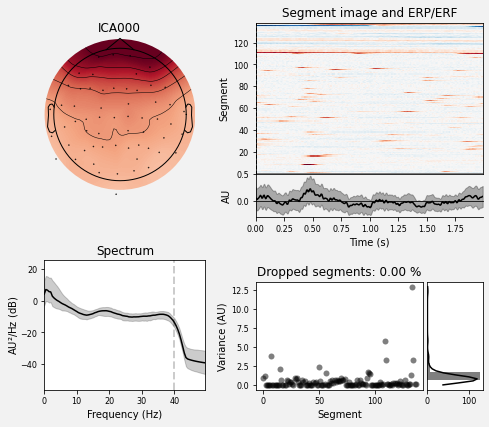

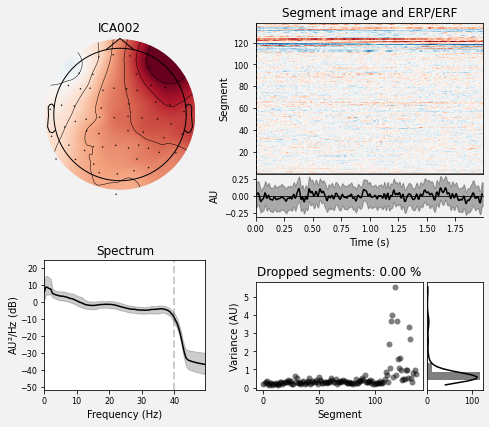

[<Figure size 504x432 with 6 Axes>, <Figure size 504x432 with 6 Axes>]

In [8]:
# Plotting the properties of the excluded components (eye blinks)
ica.plot_properties(raw, picks=ica.exclude)

Creating RawArray with float64 data, n_channels=20, n_times=41700
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


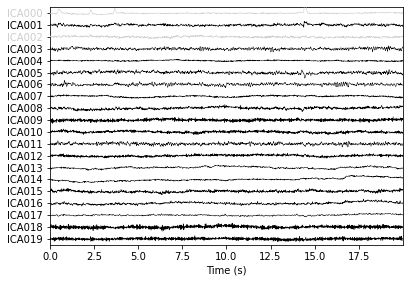

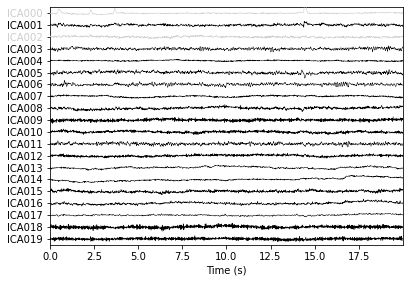

In [11]:
# Plotting the time series of the ICA after having excluded the artefacts.
# We can see that ICA000 and ICA0002 have been excluded (they are light grey)
ica.plot_sources(raw, show_scrollbars=False)

__Comparing before and after artefact removal__

In [14]:
# Making a copy (back-up) of the data
orig_raw = raw.copy()

# Load raw data into RAM (memory)
raw.load_data()

# Apply ICA on the raw data
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 59 PCA components


<Raw | sample_audvis_filt-0-40_raw.fif, 68 x 41700 (277.7 s), ~24.6 MB, data loaded>

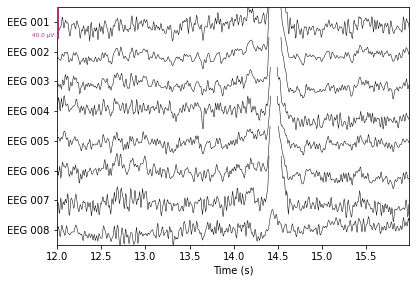

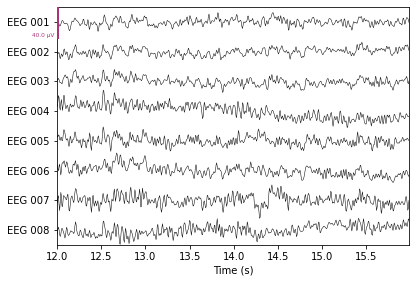

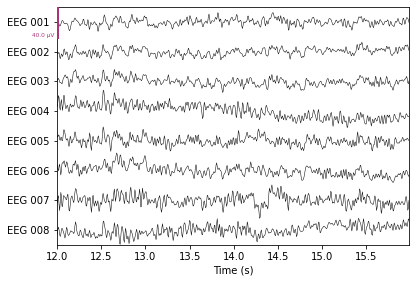

In [19]:
# Show some frontal channels to clearly illustrate the artifact removal
chs = ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006',
       'EEG 007', 'EEG 008']

chan_idxs = [raw.ch_names.index(ch) for ch in chs]
orig_raw.plot(order=chan_idxs, start=12, duration=4, show_scrollbars = False)
raw.plot(order=chan_idxs, start=12, duration=4, show_scrollbars = False)

There are many options with ICA, see
https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html
for a tutorial on ICA in MNE-python.

__Identifying events__

In [20]:
# The stimulus channel on the Electra vector view is: STI 014
# STI 014 is an aggregated stimulus channel where all the stimuli signals are combined
events = mne.find_events(raw, stim_channel='STI 014')

319 events found
Event IDs: [ 1  2  3  4  5 32]


In [22]:
# Inspecting the individual events
events
# First entry: the time point
# Second entry: ignore this
# Third entry: the stimulus presented

array([[ 6994,     0,     2],
       [ 7086,     0,     3],
       [ 7192,     0,     1],
       [ 7304,     0,     4],
       [ 7413,     0,     2],
       [ 7506,     0,     3],
       [ 7612,     0,     1],
       [ 7709,     0,     4],
       [ 7810,     0,     2],
       [ 7916,     0,     3],
       [ 8025,     0,     1],
       [ 8129,     0,     4],
       [ 8233,     0,     2],
       [ 8331,     0,     3],
       [ 8428,     0,     1],
       [ 8522,     0,     5],
       [ 8633,     0,     2],
       [ 8662,     0,    32],
       [ 8739,     0,     3],
       [ 8857,     0,     1],
       [ 8962,     0,     4],
       [ 9052,     0,     2],
       [ 9144,     0,     3],
       [ 9251,     0,     1],
       [ 9365,     0,     4],
       [ 9477,     0,     2],
       [ 9581,     0,     3],
       [ 9677,     0,     1],
       [ 9782,     0,     4],
       [ 9890,     0,     2],
       [ 9981,     0,     3],
       [10101,     0,     1],
       [10220,     0,     4],
       [10

In [23]:
# Creating a dictionary containing the individual stimuli
event_dict = {"auditory/left": 1, 
              "auditory/right": 2, 
              "visual/left": 3, 
              "visual/right": 4, 
              "smiley": 5, 
              "buttonpress": 32}

In [25]:
# Any signal from any channel above 150 mV is filtered out because this is not a brain signal
reject_criteria = dict(eeg=150e-6)  # 150 ÂµV

In [27]:
# Select only EEG data
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=True)

# Create epoch objects 
epochs = mne.Epochs(raw, 
                    events, 
                    event_dict, 
                    -.2, # when epochs begin
                    0.5, # when epochs end
                    picks=picks,
                    baseline=None, 
                    reject=reject_criteria, 
                    preload=True)

Not setting metadata
Not setting metadata
319 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 319 events and 106 original time points ...
    Rejecting  epoch based on EEG : ['EEG 008']
1 bad epochs dropped


# Comparing evokeds

To visually comparing different evoked objects it is a good idea to calculate
 a _difference  wave_, i.e. one condition minus the other condition. In
 MNE-python ```mne.combine_evokeds```can do that.

In [ ]:
# Change to your evokeds
difference_wave = mne.combine_evoked([Evoked_0, Evoked_2], weights=[1, -1])

See also:
https://mne.tools/stable/generated/mne.viz.plot_compare_evokeds.html